# **FixBi: Bridging Domain Spaces for Unsupervised Domain Adaptation** (DLCV Project Code)

[**Paper**](https://openaccess.thecvf.com/content/CVPR2021/papers/Na_FixBi_Bridging_Domain_Spaces_for_Unsupervised_Domain_Adaptation_CVPR_2021_paper.pdf)

[**Author's implementation**](https://github.com/NaJaeMin92/FixBi)

**Note**: Our implentation took inspiration from author's code and different in some details due to different version of libraries.

### Team Members

1. Parth Bansal (22ucs146)
2. Priyanshu Gupta (22ucs155)
3. Sanidhya Gupta (22ucs182)
4. Shreyansh Agarwal (22ucs203)

### Submitted to:

Dr. Preety Singh

<br>

### **Dataset**

**Source Domain**: Office-31 Amazon

**Target Domain**: Office-31 DSLR

This paper showcase experiments on multiple datasets, due to GPU time limits on Google Colab and smaller GPU memory size in free tier, we showcase only one experiment.

<br>

### **Weigths Initialization**

This paper method **don't start from random weights** for Source Dominant Model (SDM) and Target Dominant Model (TDM) but uses weights from an already trained model using [**DANN**](https://github.com/NaJaeMin92/pytorch-DANN) implementation.

We have used .pth files saved in google drive to import those weights initialization.

<br>

### **Base Model**

1. **Extractor**: ResNet-50 [(224, 224, 3) -> 2048]
2. **Classifier**: (Hidden Layer [2048 -> 256], ReLU, Output Layer [256 -> 31])


### Mouting Google Drive to Load Dataset and DANN Weights

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Libraries

We used **PyTorch** Library for this implementation.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
import numpy as np
from torch.autograd import Function
import os
import time
import itertools
import torch.nn.functional as F

In [ ]:
# Checking if GPU present or not
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Dataset Classes

In [ ]:
# Dataset Class for loading Office-31 dataset
class Office31Dataset:
    def __init__(self, root_dir):
        self.root_dir = root_dir

        # Applying Transformations on Image so that image fits in ResNet-50
        self.data_transforms = {
            'train': transforms.Compose([
                transforms.Resize([256, 256]),
                transforms.RandomCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'test': transforms.Compose([
                transforms.Resize([256, 256]),
                transforms.CenterCrop((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }

    def load_data(self, domain, split='train', batch_size=32, num_workers=4):
        # Path to the domain
        domain_path = os.path.join(self.root_dir, domain)

        # Create dataset using ImageFolder
        dataset = ImageFolder(
            root=domain_path,
            transform=self.data_transforms[split]
        )

        # Print classes for reference
        print(f"Classes in {domain} domain: {dataset.classes}")
        print(f"Number of images: {len(dataset)}")

        # Create DataLoader
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=(split == 'train'),  # Shuffle only for training
            num_workers=num_workers,
            pin_memory=True,
            drop_last=(split == 'train')  # Drop last batch only for training
        )

        return dataloader, dataset

# If a dataloader is of smaller size, make it inifinite loader (loop again to itself)
def create_infinite_loader(dataloader):
    return itertools.cycle(dataloader)

### Model Architecture (nn.Module)

In [ ]:
# Feature Extractor (ResNet-50)
class Extractor(nn.Module):
    def __init__(self):
        super(Extractor, self).__init__()
        resnet = models.resnet50(pretrained=False)
        self.feature = nn.Sequential(*list(resnet.children())[:-1])  # Remove final FC

    def forward(self, x):
        x = self.feature(x)        # [B, 2048, 1, 1]
        return x.view(x.size(0), -1)  # [B, 2048]

# Classifier (comes after Feature Extractor)
class Classifier(nn.Module):
    def __init__(self, num_classes=31):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(2048, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

In [ ]:
# hyperparemeters
workers = 2
num_classes = 31
batch_size = 8
accumulation_steps = 4
epochs = 50             # Epochs are less because we start with a pre-trained weights from DANN

# Warm-Up Epochs
bim_start = 25
sp_start = 25
cr_start = 25

### DataLoaders Initialization

In [ ]:
# Loading Datasets
office31 = Office31Dataset("/content/drive/MyDrive/BXT/DLCV")

# For Source Domain
source_train_loader, _ = office31.load_data(
    domain='Office31_amazon',
    split='train',
    batch_size=batch_size,
    num_workers=workers
)

source_test_loader, _ = office31.load_data(
    domain='Office31_amazon',
    split='test',
    batch_size=batch_size,
    num_workers=workers
)

# For Target Domain
target_train_loader, _ = office31.load_data(
    domain='Office31_dslr',
    split='train',
    batch_size=batch_size,
    num_workers=workers
)

target_test_loader, _ = office31.load_data(
    domain='Office31_dslr',
    split='test',
    batch_size=batch_size,
    num_workers=workers
)

# Target Domain size is smaller than Source Domain size
# Converting it to infinite DataLoader
inf_target_train = create_infinite_loader(target_train_loader)

Classes in Office31_amazon domain: ['back_pack', 'bike', 'bike_helmet', 'bookcase', 'bottle', 'calculator', 'desk_chair', 'desk_lamp', 'desktop_computer', 'file_cabinet', 'headphones', 'keyboard', 'laptop_computer', 'letter_tray', 'mobile_phone', 'monitor', 'mouse', 'mug', 'paper_notebook', 'pen', 'phone', 'printer', 'projector', 'punchers', 'ring_binder', 'ruler', 'scissors', 'speaker', 'stapler', 'tape_dispenser', 'trash_can']
Number of images: 2817
Classes in Office31_amazon domain: ['back_pack', 'bike', 'bike_helmet', 'bookcase', 'bottle', 'calculator', 'desk_chair', 'desk_lamp', 'desktop_computer', 'file_cabinet', 'headphones', 'keyboard', 'laptop_computer', 'letter_tray', 'mobile_phone', 'monitor', 'mouse', 'mug', 'paper_notebook', 'pen', 'phone', 'printer', 'projector', 'punchers', 'ring_binder', 'ruler', 'scissors', 'speaker', 'stapler', 'tape_dispenser', 'trash_can']
Number of images: 2817
Classes in Office31_dslr domain: ['back_pack', 'bike', 'bike_helmet', 'bookcase', 'bottl

### Viewing samples from the Datasets

=== Source Domain Batch ===
  Images tensor shape : torch.Size([8, 3, 224, 224])
  Labels tensor shape : torch.Size([8])

=== Target Domain Batch ===
  Images tensor shape : torch.Size([8, 3, 224, 224])
  Labels tensor shape : torch.Size([8])

First 10 source labels: [19, 19, 29, 28, 24, 12, 17, 18]
First 10 target labels: [17, 28, 7, 29, 21, 26, 12, 12]


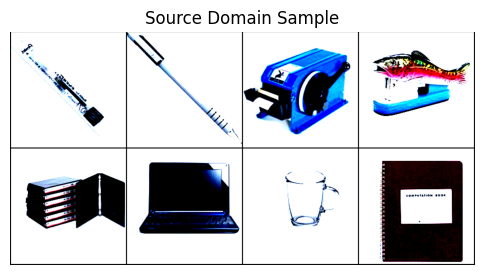

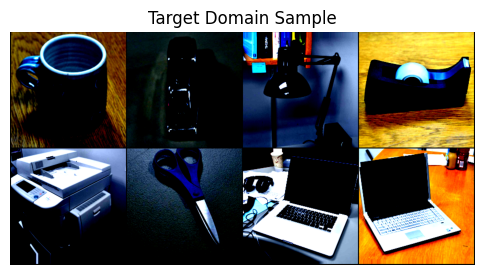

In [ ]:
source_iter = iter(source_train_loader)
target_iter = iter(target_train_loader)

src_imgs, src_lbls = next(source_iter)
tgt_imgs, tgt_lbls = next(target_iter)

print("=== Source Domain Batch ===")
print(f"  Images tensor shape : {src_imgs.shape}")   # e.g. (batch_size, 3, 224, 224)
print(f"  Labels tensor shape : {src_lbls.shape}")   # e.g. (batch_size,)

print("\n=== Target Domain Batch ===")
print(f"  Images tensor shape : {tgt_imgs.shape}")
print(f"  Labels tensor shape : {tgt_lbls.shape}")

print("\nFirst 10 source labels:", src_lbls[:10].tolist())
print("First 10 target labels:", tgt_lbls[:10].tolist())

import torchvision.utils as vutils
import matplotlib.pyplot as plt

def show_grid(imgs, title):
    grid = vutils.make_grid(imgs[:8], nrow=4, padding=2).permute(1,2,0).cpu().numpy()
    plt.figure(figsize=(6,6))
    plt.title(title)
    plt.axis('off')
    plt.imshow(grid)
    plt.show()

show_grid(src_imgs, "Source Domain Sample")
show_grid(tgt_imgs, "Target Domain Sample")

### Loading Weights from .pth file

In [ ]:
# Path to load initial weights
extractor_weights_path = '/content/drive/MyDrive/BXT/DLCV/extractor_dann.pth'
classifier_weights_path = '/content/drive/MyDrive/BXT/DLCV/classifier_dann.pth'

# Source Dominant Model
net_sd = Extractor().to(device)
classifier_sd = Classifier().to(device)

# Target Dominant Model
net_td = Extractor().to(device)
classifier_td = Classifier().to(device)

# Setting Initial Weights to Both Models
net_sd.load_state_dict(torch.load(extractor_weights_path, map_location=device))
net_td.load_state_dict(torch.load(extractor_weights_path, map_location=device))
classifier_sd.load_state_dict(torch.load(classifier_weights_path, map_location=device))
classifier_td.load_state_dict(torch.load(classifier_weights_path, map_location=device))

# List of Learnable Parameters
learnable_params_sd = list(net_sd.parameters()) + list(classifier_sd.parameters())
learnable_params_td = list(net_td.parameters()) + list(classifier_td.parameters())

models_sd = [net_sd, classifier_sd]
models_td = [net_td, classifier_td]

# Self-Penalizing Parameter
sp_param_sd = nn.Parameter(torch.tensor(5.0).cuda(), requires_grad=True)
sp_param_td = nn.Parameter(torch.tensor(5.0).cuda(), requires_grad=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# Lambda and Threshold Values
lam_sd = 0.7
lam_td = 0.3
th = 2.0

# SGD hyperparameters
lr = 0.001
l2_decay = 5e-4
momentum = 0.9
nesterov = False

optimizer_sd = optim.SGD(learnable_params_sd, lr=lr, momentum=momentum, weight_decay=l2_decay, nesterov=nesterov)
optimizer_td = optim.SGD(learnable_params_td, lr=lr, momentum=momentum, weight_decay=l2_decay, nesterov=nesterov)

optimizer_sd.add_param_group({"params": [sp_param_sd], "lr": lr})
optimizer_td.add_param_group({"params": [sp_param_td], "lr": lr})

ce = nn.CrossEntropyLoss().cuda()
mse = nn.MSELoss().cuda()

### Utility Functions used for Training

In [ ]:
fixed_mixup_sdm = []
fixed_mixup_tdm = []
bidirectional_sdm = [None]*bim_start + []
bidirectional_tdm = [None]*bim_start + []
penalization_sdm = []
penalization_tdm = []
consistency_loss = [None]*cr_start + []
sdm_accuracy = []
tdm_accuracy = []
overall_accuracy = []


In [ ]:
def get_target_preds(x):
    top_prob, top_label = torch.topk(F.softmax(x, dim=1), k=1)
    top_label = top_label.squeeze().t()
    top_prob = top_prob.squeeze().t()
    top_mean, top_std = top_prob.mean(), top_prob.std()
    threshold = top_mean - th * top_std
    return top_label, top_prob, threshold

def mixup_criterion_hard(pred, y_a, y_b, lam):
    criterion = nn.CrossEntropyLoss().cuda()
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def get_sp_loss(input, target, temp):
    criterion = nn.NLLLoss(reduction='none').cuda()
    loss = torch.mul(criterion(torch.log(1 - F.softmax(input / temp, dim=1)), target.detach()), 1).mean()
    return loss

def get_fixmix_loss(net, classifier, src_imgs, tgt_imgs, src_labels, tgt_pseudo, ratio):
    mixed_x = ratio * src_imgs + (1 - ratio) * tgt_imgs
    features = net(mixed_x)
    outputs = classifier(features)
    loss = mixup_criterion_hard(outputs, src_labels.detach(), tgt_pseudo.detach(), ratio)
    return loss

def evaluate(models, loader, arr):
    start = time.time()
    total = 0
    correct = 0
    for model in models_sd:
        model.eval()
    for model in models_td:
        model.eval()
    with torch.no_grad():
        for step, tgt_data in enumerate(loader):
            tgt_imgs, tgt_labels = tgt_data
            tgt_imgs, tgt_labels = tgt_imgs.cuda(non_blocking=True), tgt_labels.cuda(non_blocking=True)
            tgt_preds = models(tgt_imgs)
            pred = tgt_preds.argmax(dim=1, keepdim=True)
            correct += pred.eq(tgt_labels.long().view_as(pred)).sum().item()
            total += tgt_labels.size(0)

    print('Accuracy: {:.2f}%'.format((correct / total) * 100))
    arr.append((correct / total) * 100)
    print("Eval time: {:.2f}".format(time.time() - start))

def final_eval(models_sd, models_td, tgt_test_loader):
    total = 0
    correct = 0
    for model in models_sd:
        model.eval()
    for model in models_td:
        model.eval()

    with torch.no_grad():
        for step, tgt_data in enumerate(tgt_test_loader):
            tgt_imgs, tgt_labels = tgt_data
            tgt_imgs, tgt_labels = tgt_imgs.cuda(), tgt_labels.cuda()
            pred_sd = F.softmax(models_sd(tgt_imgs), dim=1)
            pred_td = F.softmax(models_td(tgt_imgs), dim=1)
            softmax_sum = pred_sd + pred_td
            _, final_pred = torch.topk(softmax_sum, 1)
            correct += final_pred.eq(tgt_labels.long().view_as(final_pred)).sum().item()
            total += tgt_labels.size(0)

    print('Final Accuracy: {:.2f}%'.format((correct / total) * 100))
    overall_accuracy.append((correct / total) * 100)

### Training Model

In [ ]:
def train_fixbi(models_sd, models_td, epoch):

    for model in models_sd:
        model.train()
    for model in models_td:
        model.train()

    net_sd, classifier_sd = models_sd
    net_td, classifier_td = models_td

    for step, source_data in enumerate(source_train_loader):
        # Get a batch from the infinite target loader
        target_data = next(inf_target_train)

        # Now we have a batch from both domains
        source_images, source_labels = source_data
        target_images, target_labels = target_data

        # Send to GPU
        source_images = source_images.to(device, non_blocking=True)
        source_labels = source_labels.to(device, non_blocking=True)
        target_images = target_images.to(device, non_blocking=True)
        target_labels = target_labels.to(device, non_blocking=True)

        features_sd = net_sd(target_images)
        x_sd = classifier_sd(features_sd)

        features_td = net_td(target_images)
        x_td = classifier_td(features_td)

        pseudo_sd, top_prob_sd, threshold_sd = get_target_preds(x_sd)
        fixmix_sd_loss = get_fixmix_loss(net_sd, classifier_sd, source_images, target_images, source_labels, pseudo_sd, lam_sd)

        pseudo_td, top_prob_td, threshold_td = get_target_preds(x_td)
        fixmix_td_loss = get_fixmix_loss(net_td, classifier_td, source_images, target_images, source_labels, pseudo_td, lam_td)

        total_loss = fixmix_sd_loss + fixmix_td_loss

        if step == 0:
            print('Fixed MixUp Loss (SDM): {:.4f}'.format(fixmix_sd_loss.item()))
            fixed_mixup_sdm.append(fixmix_sd_loss.item())
            print('Fixed MixUp Loss (TDM): {:.4f}'.format(fixmix_td_loss.item()))
            fixed_mixup_tdm.append(fixmix_td_loss.item())

        # Bidirectional Matching
        if epoch >= bim_start:
            bim_mask_sd = torch.ge(top_prob_sd, threshold_sd)
            bim_mask_sd = torch.nonzero(bim_mask_sd).squeeze()

            bim_mask_td = torch.ge(top_prob_td, threshold_td)
            bim_mask_td = torch.nonzero(bim_mask_td).squeeze()

            if bim_mask_sd.dim() > 0 and bim_mask_td.dim() > 0:
                if bim_mask_sd.numel() > 0 and bim_mask_td.numel() > 0:
                    bim_mask = min(bim_mask_sd.size(0), bim_mask_td.size(0))
                    bim_sd_loss = ce(x_sd[bim_mask_td[:bim_mask]], pseudo_td[bim_mask_td[:bim_mask]].cuda().detach())
                    bim_td_loss = ce(x_td[bim_mask_sd[:bim_mask]], pseudo_sd[bim_mask_sd[:bim_mask]].cuda().detach())

                    total_loss += bim_sd_loss
                    total_loss += bim_td_loss

                    if step == 0:
                        print('Bidirectional Loss (SDM): {:.4f}'.format(bim_sd_loss.item()))
                        bidirectional_sdm.append(bim_sd_loss.item())
                        print('Bidirectional Loss (TDM): {:.4f}'.format(bim_td_loss.item()))
                        bidirectional_tdm.append(bim_td_loss.item())

        # Self-penalization
        if epoch <= sp_start:
            sp_mask_sd = torch.lt(top_prob_sd, threshold_sd)
            sp_mask_sd = torch.nonzero(sp_mask_sd).squeeze()

            sp_mask_td = torch.lt(top_prob_td, threshold_td)
            sp_mask_td = torch.nonzero(sp_mask_td).squeeze()

            if sp_mask_sd.dim() > 0 and sp_mask_td.dim() > 0:
                if sp_mask_sd.numel() > 0 and sp_mask_td.numel() > 0:
                    sp_mask = min(sp_mask_sd.size(0), sp_mask_td.size(0))
                    sp_sd_loss = get_sp_loss(x_sd[sp_mask_sd[:sp_mask]], pseudo_sd[sp_mask_sd[:sp_mask]], sp_param_sd)
                    sp_td_loss = get_sp_loss(x_td[sp_mask_td[:sp_mask]], pseudo_td[sp_mask_td[:sp_mask]], sp_param_td)

                    total_loss += sp_sd_loss
                    total_loss += sp_td_loss

                    if step == 0:
                        print('Penalization Loss (SDM): {:.4f}', sp_sd_loss.item())
                        penalization_sdm.append(sp_sd_loss.item())
                        print('Penalization Loss (TDM): {:.4f}', sp_td_loss.item())
                        penalization_tdm.append(sp_td_loss.item())

        # Consistency Regularization
        if epoch >= cr_start:
            mixed_cr = 0.5 * source_images + 0.5 * target_images
            features_sd = net_sd(mixed_cr)
            out_sd = classifier_sd(features_sd)

            features_td = net_td(mixed_cr)
            out_td = classifier_td(features_td)

            cr_loss = mse(out_sd, out_td)
            total_loss += cr_loss
            if step == 0:
                print('Consistency Loss: {:.4f}', cr_loss.item())
                consistency_loss.append(cr_loss.item())

        if (step) % accumulation_steps == 1:
            optimizer_sd.zero_grad()
            optimizer_td.zero_grad()
            total_loss.backward()
            optimizer_sd.step()
            optimizer_td.step()
            #print("Update")
        #print("Step", step)




for epoch in range(epochs):
    print("\n\nEpoch: [{}/{}]\n\n".format(epoch, epochs - 1))
    start = time.time()

    train_fixbi(models_sd, models_td, epoch)

    print("Train time: {:.2f}".format(time.time() - start))

    evaluate(nn.Sequential(*models_sd), target_test_loader, sdm_accuracy)
    evaluate(nn.Sequential(*models_td), target_test_loader, tdm_accuracy)
    final_eval(nn.Sequential(*models_sd), nn.Sequential(*models_td), target_test_loader)



Epoch: [0/49]


Fixed MixUp Loss (SDM): 2.0656
Fixed MixUp Loss (TDM): 3.1043
Train time: 353.69
Accuracy: 67.07%
Eval time: 6.66
Accuracy: 63.45%
Eval time: 8.20
Final Accuracy: 68.67%


Epoch: [1/49]


Fixed MixUp Loss (SDM): 1.7373
Fixed MixUp Loss (TDM): 2.1470
Train time: 51.90
Accuracy: 74.50%
Eval time: 8.26
Accuracy: 64.46%
Eval time: 6.74
Final Accuracy: 72.29%


Epoch: [2/49]


Fixed MixUp Loss (SDM): 1.9026
Fixed MixUp Loss (TDM): 2.0047
Train time: 52.70
Accuracy: 72.09%
Eval time: 6.79
Accuracy: 62.65%
Eval time: 8.52
Final Accuracy: 69.08%


Epoch: [3/49]


Fixed MixUp Loss (SDM): 2.3271
Fixed MixUp Loss (TDM): 2.1235
Train time: 53.42
Accuracy: 72.29%
Eval time: 7.94
Accuracy: 62.45%
Eval time: 7.39
Final Accuracy: 71.49%


Epoch: [4/49]


Fixed MixUp Loss (SDM): 1.8547
Fixed MixUp Loss (TDM): 1.8474
Train time: 53.18
Accuracy: 74.30%
Eval time: 6.79
Accuracy: 64.26%
Eval time: 8.41
Final Accuracy: 72.89%


Epoch: [5/49]


Fixed MixUp Loss (SDM): 1.8613
Fixed MixUp Los

### Saving Model Weights

In [ ]:
torch.save(net_sd.state_dict(), 'extractor_sd.pth')
torch.save(classifier_sd.state_dict(), 'classifier_sd.pth')
torch.save(net_td.state_dict(), 'extractor_td.pth')
torch.save(classifier_td.state_dict(), 'classifier_td.pth')

### Plotting Graphs

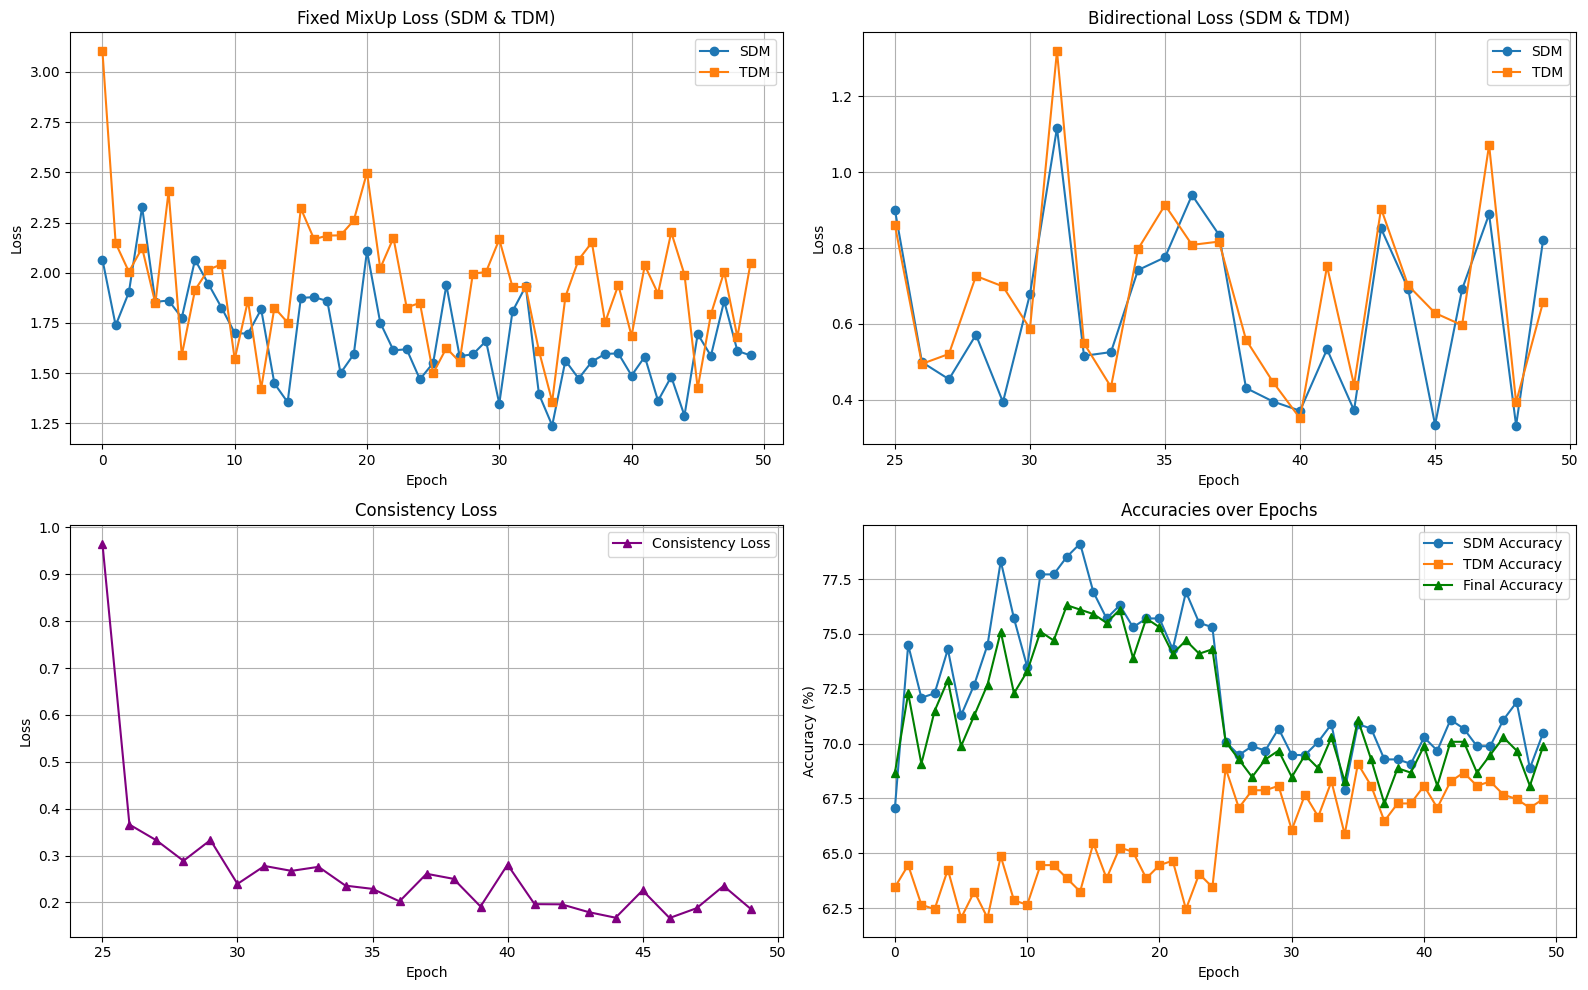

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(len(fixed_mixup_sdm)))

# Create 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Fixed MixUp Loss
axs[0, 0].plot(epochs, fixed_mixup_sdm, label='SDM', marker='o')
axs[0, 0].plot(epochs, fixed_mixup_tdm, label='TDM', marker='s')
axs[0, 0].set_title('Fixed MixUp Loss (SDM & TDM)')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot 2: Bidirectional Loss
axs[0, 1].plot(epochs, bidirectional_sdm, label='SDM', marker='o')
axs[0, 1].plot(epochs, bidirectional_tdm, label='TDM', marker='s')
axs[0, 1].set_title('Bidirectional Loss (SDM & TDM)')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot 3: Consistency Loss
axs[1, 0].plot(epochs, consistency_loss, label='Consistency Loss', color='purple', marker='^')
axs[1, 0].set_title('Consistency Loss')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot 4: Accuracies
axs[1, 1].plot(epochs, sdm_accuracy, label='SDM Accuracy', marker='o')
axs[1, 1].plot(epochs, tdm_accuracy, label='TDM Accuracy', marker='s')
axs[1, 1].plot(epochs, overall_accuracy, label='Final Accuracy', color='green', marker='^')
axs[1, 1].set_title('Accuracies over Epochs')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Accuracy (%)')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()